# Legalis SKOPS Predictor
#### Notebook used to create and publish an sckit-learn text classification modek for outcome prediction

## Libary and Dataset Import

In [82]:
!pip install datasets
!pip install skops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
# imports for utility
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tempfile import mkdtemp, mkstemp
import os

#nltk imports for stop words
import nltk
nltk.download('stopwords')

#sklearn import for model creation
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#imports to pull/push to/from huggingface hub and create an interactive pipeline
from sklearn.pipeline import Pipeline
import datasets as ds
from skops import card, hub_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### preprocessing dataset again (stripping down and changing names)

In [84]:
hgf_dataset=ds.load_dataset("lennardzuendorf/legalis")
dataset=ds.concatenate_datasets([hgf_dataset['train'], hgf_dataset['test']])
dataset=dataset.remove_columns(['id', 'file_number', 'date', 'type', 'content', 'tenor','reasoning'])
dataset=dataset.rename_column('facts', 'text')
dataset=dataset.rename_column('winner', 'target')

print(dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'target', 'label'],
    num_rows: 2801
})


In [85]:
def count_dist(dataset):

    counter_zero=0
    counter_one=0

    for case in dataset:
        if case['label']==1:
            counter_one+=1
        elif case['label']==0:
            counter_zero+=1

    dist=[round(counter_zero/(counter_zero+counter_one),2),round(counter_one/(counter_zero+counter_one),2)]

    data={'Verklagte*r': [counter_zero, dist[0]], 'Klaeger*in': [counter_one, dist[1]]}
    index=['case nmb.', 'case dist.']

    return pd.DataFrame(data=data, index=index)

## Predifining Function to run several times with different dataset sizes
#### function for dataframe creation with variable size and splitting into test, train

In [86]:
def create_dataset(size, test_size):

    df_dataset=pd.DataFrame(dataset[:size])
    df_train, df_test = train_test_split(df_dataset, test_size=test_size)

    return df_train, df_test

#### function to vectorize words and get rid of german stopwords with nltk

In [87]:
from nltk.corpus import stopwords
stop_words=stopwords.words('german')

def vectorize_words_stop(df_train, df_test):

    vec = CountVectorizer(
        ngram_range=(1, 3),
        stop_words=stop_words,
    )

    X_train = vec.fit_transform(df_train.text)
    X_test = vec.transform(df_test.text)

    y_train = df_train.target
    y_test = df_test.target

    return X_train, X_test, y_train, y_test

#### block for fitting models and returning reports

In [88]:
def mulitmodel_fitter(X_train, y_train, X_test, y_test):
  nb = MultinomialNB()
  nb.fit(X_train, y_train)

  predict = nb.predict(X_test)
  return classification_report(y_test, predict, output_dict=True)

def forest_fitter(X_train, y_train, X_test, y_test, config):
  rf = RandomForestClassifier(random_state=0, **config)
  rf.fit(X_train, y_train)

  predict = rf.predict(X_test)
  return  classification_report(y_test, predict, output_dict=True)

#### block for the random forest tuning function

In [89]:
def forest_tuner(X_train, y_train, n_iter, cv, random_state):

  param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [None, 5, 10, 15],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'max_features': ['log2', 'sqrt'],
      'bootstrap': [True, False],
  }

  random_search = RandomizedSearchCV(
      estimator=RandomForestClassifier(),
      param_distributions=param_grid,
      n_iter=n_iter,
      cv=cv,
      random_state=random_state
  )

  random_search.fit(X_train, y_train)
  return random_search.best_params_, random_search.cv_results_


## Running Model with different dataset sizes
#### functions to run model with different sizes or with/without stop words and extract, plot stats from it

In [90]:
def mutimodal_runner(run_list):
  output=[]

  for run in run_list:
    df_train, df_test = create_dataset(run, 0.2)
    X_train, X_test, y_train, y_test = vectorize_words_stop(df_train, df_test)
    report = mulitmodel_fitter(X_train, y_train, X_test, y_test)
    output.append(report)

  return output

def forest_runner(run_list, n_iter, cv, random_state):
  tuning_results=[]
  fitting_results=[]

  for run in run_list:
    df_train, df_test = create_dataset(run, 0.2)
    X_train, X_test, y_train, y_test = vectorize_words_stop(df_train, df_test)

    config, results=forest_tuner(X_train, y_train, n_iter, cv, random_state)
    tuning_results.append(results)

    report = forest_fitter(X_train, y_train, X_test, y_test, config)
    fitting_results.append(report)


  return tuning_results, fitting_results

In [103]:
def stat_extractor(run_stats, run_nmbs):
  data={}
  index=['precision Klaeger*in', 'precision Verklagte*r', 'overall accuracy', 'macro avg', 'weighted avg']

  i=0

  for run in run_stats:
    df=pd.DataFrame.from_dict(run)
    values = df.values[:1][0].round(decimals=3)
    run_data={str(run_nmbs[i]): values}
    data.update(run_data)
    i=i+1

  return pd.DataFrame(data=data, index=index)

def fitting_plotter(run_stats, mode):
  df = run_stats
  df_filtered = run_stats.drop("macro avg")
  if mode=='multimodal':
    title='naive bayes multimodal performance with different dataset sizes'
  else:
    title='random forest performance with different dataset sizes'

  # Create a figure and subplots
  fig, axs = plt.subplots(2, 2, figsize=(8, 8))
  fig.suptitle(title, fontsize=16)
  fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
  axs = axs.flatten()

  # creat subplot for each of the 4 left over metrics
  for i, metric in enumerate(df_filtered.index[:4]):
      axs[i].plot(df.columns, df_filtered.loc[metric], marker='o')
      axs[i].set_title(metric)

  # set labels
  for ax in axs:
      ax.set_xlabel('nmb. of cases')
  axs[0].set_ylabel('Precision')
  axs[1].set_ylabel('Accuracy')

  # Display the plot
  plt.show()

def tuning_plotter(cv_results_list, run_nmbs):
    num_runs = len(cv_results_list)
    num_plots = num_runs

    # Determine the number of rows and columns for subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(f"search test scores across {num_plots} runs with different dataset sizes", fontsize=16)
    fig.tight_layout(pad=3.0)

    # Flatten the axis array if there is only one row or column
    if num_plots == 1:
        axs = np.array([axs])

    # Iterate over the cv_results list and plot the test scores
    for i, cv_results in enumerate(cv_results_list):
        # Extract the test scores
        test_scores = cv_results['mean_test_score']

        # Create the x-axis values (iteration index)
        iteration_index = np.arange(1, len(test_scores) + 1)

        # Determine the subplot location
        row = i // num_cols
        col = i % num_cols

        # Create a scatter plot in the corresponding subplot
        axs[row, col].scatter(iteration_index, test_scores)
        axs[row, col].set_xticks(range(0, len(test_scores) + 1, 1))
        axs[row, col].set_xlabel('Iteration')
        axs[row, col].set_ylabel('Test Score')
        axs[row, col].set_title(f'Run with {run_nmbs[i]} cases')

    # Remove any empty subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axs[row, col])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

#### running and displaying stats for multimodal model with different dataset sizes

,1000,2000,2400,2800
precision Klaeger*in,0.786,0.667,0.644,0.714
precision Verklagte*r,0.694,0.625,0.680,0.670
overall accuracy,0.700,0.628,0.677,0.673
macro avg,0.740,0.646,0.662,0.692
weighted avg,0.725,0.641,0.668,0.686


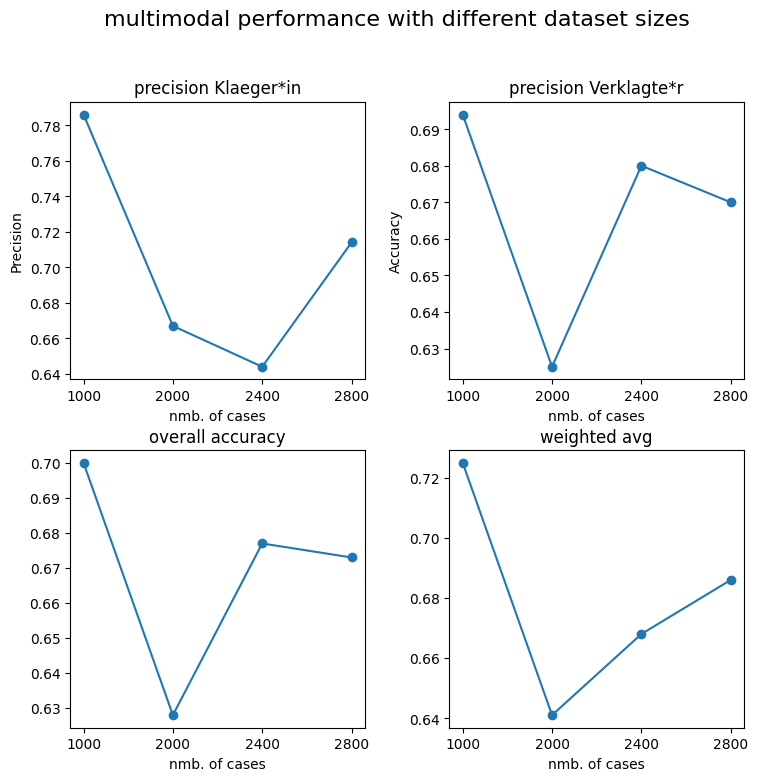

In [44]:
run_nmbs=[1000, 2000, 2400, 2800]
multimodal_run_stats=mutimodal_runner(run_nmbs)
multimodal_run_stats=stat_extractor(multimodal_run_stats, run_nmbs)

display(multimodal_run_stats)
fitting_plotter(multimodal_run_stats, mode="multimodal")

#### tuning and running random forest classifier for different data sizes, plotting results

,1000,2000,2400,2800
precision Klaeger*in,1.000,0.824,0.793,0.875
precision Verklagte*r,0.653,0.569,0.627,0.638
overall accuracy,0.660,0.580,0.638,0.648
macro avg,0.827,0.696,0.710,0.757
weighted avg,0.778,0.683,0.693,0.729


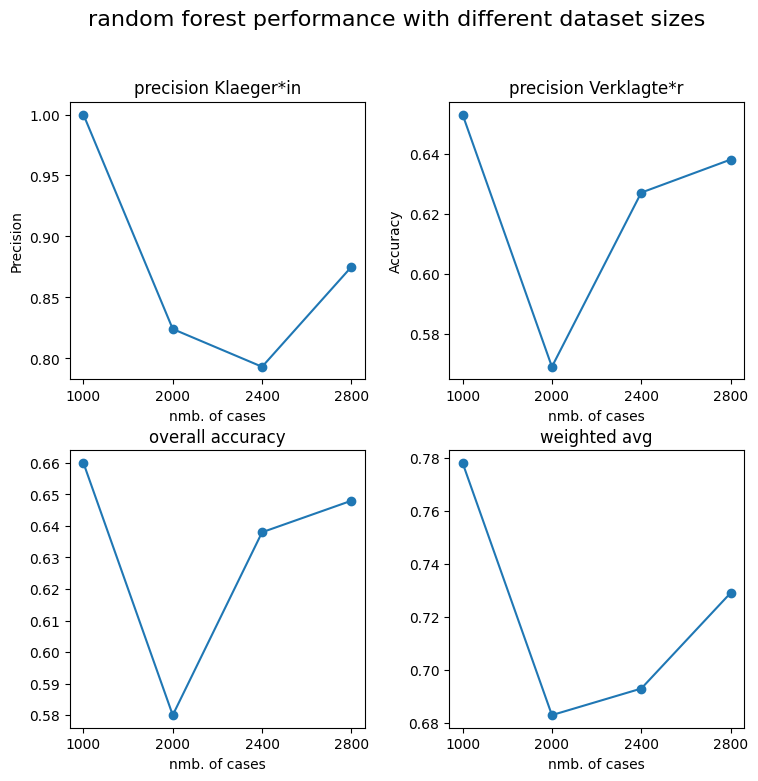

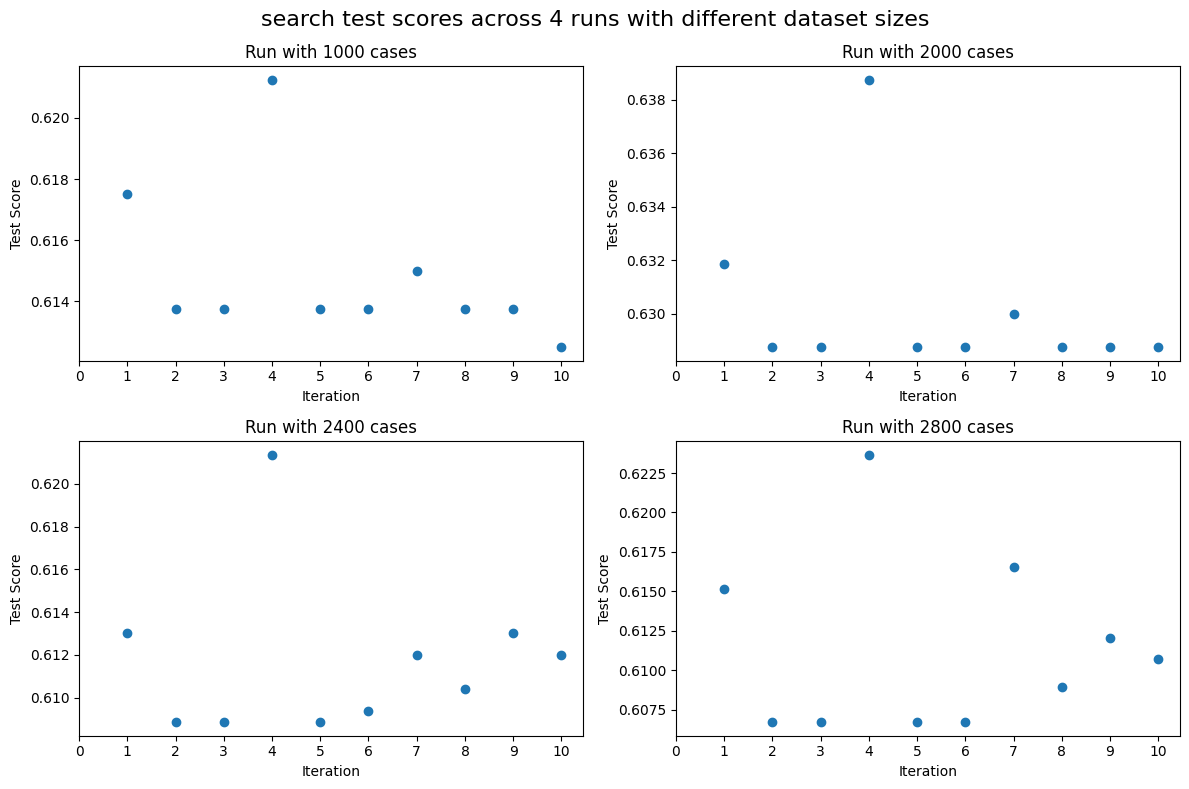

In [107]:
run_nmbs=[1000, 2000, 2400, 2800]

tuning_results, fitting_results=forest_runner(run_nmbs, n_iter=10, cv=2, random_state=42)
fitting_results=stat_extractor(fitting_results, run_nmbs)

display(fitting_results)
print("\n")
fitting_plotter(fitting_results, mode="forest")
print("\n")
tuning_plotter(tuning_results, run_nmbs)